###### 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K1
from tensorflow.keras.layers import Layer
#from tensorflow.keras.engine.topology import Layer

def init_identities(shape, dtype=None):
    out = np.zeros(shape)
    for r in range(shape[2]):
        for i in range(shape[0]):
            out[i,i,r] = 1.0
    return out
    
class CrowdsClassification(Layer):


  
  #The build() method’s role is to create the layer’s variables, by calling the 
  #add_weight() method for each weight.  which is often necessary to create some of the weights.
  #we need to know the number of neurons in the previous layer in order to create the connection weights matrix (i.e., the "kernel"): 
  #this corresponds to the size of the last dimension of the inputs. 
   
    def __init__(self, output_dim, num_annotators, conn_type="MW", **kwargs):
        self.output_dim = output_dim
        self.num_annotators = num_annotators
        self.conn_type = conn_type
        super(CrowdsClassification, self).__init__(**kwargs)



    def build(self, input_shape):
        if self.conn_type == "MW":
            # matrix of weights per annotator
      #A layer is a callable object that takes as input one or more tensors and that outputs one or more tensors. 
      #It involves computation, defined in the call() method, and a state (weight variables). 
      #the method add_weight() offers a shortcut to create weights.

            self.kernel = self.add_weight("CrowdLayer", (self.output_dim, self.output_dim, self.num_annotators),
                                            initializer=init_identities, #It is the stated initializer instance
                                            trainable=True) # trainable weights, updated via backpropagation during training
        elif self.conn_type == "VW":
            # vector of weights (one scale per class) per annotator
            self.kernel = self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Ones(), 
                                            trainable=True)
        elif self.conn_type == "VB":
            # two vectors of weights (one scale and one bias per class) per annotator
            self.kernel = []
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Zeros(),
                                            trainable=True))
        elif self.conn_type == "VW+B":
            # two vectors of weights (one scale and one bias per class) per annotator
            self.kernel = []
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Ones(),
                                            trainable=True))
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Zeros(),
                                            trainable=True))
        elif self.conn_type == "SW":
            # single weight value per annotator
            self.kernel = self.add_weight("CrowdLayer", (self.num_annotators,1),
                                            initializer=keras.initializers.Ones(),
                                            trainable=True)
        else:
            raise Exception("Unknown connection type for CrowdsClassification layer!")
    #At the end of the build() method (and only at the end), 
    #you must call the parent’s build() method: this tells Keras that the layer is built (it just sets self.built = True).
        super(CrowdsClassification, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
    
    #The call() method actually performs the desired operations. In this case, 
    #we compute the matrix multiplication of the inputs X and the layer’s kernel and 
    #this gives us the output of the layer.
     
 

        if self.conn_type == "MW":
            res = K1.dot(x, self.kernel)
        elif self.conn_type == "VW" or self.conn_type == "VB" or self.conn_type == "VW+B" or self.conn_type == "SW":
            out = []
            for r in range(self.num_annotators):
                if self.conn_type == "VW":
                    out.append(x * self.kernel[:,r])
                elif self.conn_type == "VB":
                    out.append(x + self.kernel[0][:,r])
                elif self.conn_type == "VW+B":
                    out.append(x * self.kernel[0][:,r] + self.kernel[1][:,r])
                elif self.conn_type == "SW":
                    out.append(x * self.kernel[r,0])
            res = tf.stack(out)
            if len(res.shape) == 3:
                res = tf.transpose(res, [1, 2, 0])
            elif len(res.shape) == 4:
                res = tf.transpose(res, [1, 2, 3, 0])
            else:
                raise Exception("Wrong number of dimensions for output")
        else:
            raise Exception("Unknown connection type for CrowdsClassification layer!") 
        
        return res
 
#The compute_output_shape() method simply returns the shape of this layer’s outputs. 
#In this case, it is the same shape as the inputs, except the last two dimensions is replaced 
#with the number of clases and # annotators in the layer.  
 

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim, self.num_annotators)
    
class MaskedMultiCrossEntropy(object):

	def loss(self, y_true, y_pred):
		vec = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true, axis = 1)
		mask = tf.equal(y_true[:,0,:], -1)
		zer = tf.zeros_like(vec)
		loss = tf.where(mask, x=zer, y=vec)
		return loss


In [2]:
def custom_CLR_loss(y_true, y_pred): #ytrue \in N x R,  ypred \in N x K x R  ->CrowdLayerRodriguez
    #tf.print(y_true)
    K=2
    Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth= K,axis=1) #samples, classes 1-K, annotators
    #tf.print(Y_true_1K)
    #print(Y_true_1K.shape)    
    vec = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=Y_true_1K, axis = 1)
    tf.print(y_pred)
    #print(vec.shape)
    #mask = tf.equal(Y_true_1K[:,0,:], -1)
    #zer = tf.zeros_like(vec)
    #loss = tf.where(mask, x=zer, y=vec)
    #tf.print("loss", loss)
    return tf.math.reduce_sum(vec)

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
import time

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model

class MultipleAnnotators_Classification():
  def __init__(self, output_dim, num_annotators):
    self.K = output_dim
    self.R = num_annotators

  def CrowdLayer(self, input):
    x = keras.layers.Dense(self.R + self.K,activation='tanh')(input)
    output_cla = keras.layers.Dense(self.K, activation='softmax')(x)
    output_ann = keras.layers.Dense(self.R, activation='sigmoid')(x)
    output = keras.layers.Concatenate()([output_cla, output_ann])
    return output

  #RCDNN   
  def loss(self):
        def custom_loss(y_true, y_pred):
            # print(y_true,y_pred)
            pred = y_pred[:, :self.K]
            pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1-1e-9) #estabilidad numerica de la funcion de costo
            ann_ = y_pred[:, self.K:]
            Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
            Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)
            p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
            temp1 = ann_*tf.math.log(p_logreg)  
            temp2 = (1 - ann_)*tf.math.log(1/self.K)*tf.reduce_sum(Y_true,axis=1)
            # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
            # print(tf.reduce_mean(Y_true,axis=1).numpy())
            return -tf.math.reduce_sum((temp1 + temp2))
        return custom_loss  
    
  @tf.function
  def train_step(self, x, Y, y=None):
      with tf.GradientTape() as tape:
          logits = self.model(x, training=True)
          loss_value = self.loss_fn(Y, logits)
      grads = tape.gradient(loss_value, self.model.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
      if y is not None:
      	self.train_acc_metric.update_state(y, logits[:, :self.K])
      return loss_value

  @tf.function
  def test_step(self, x, y):
      val_logits = self.model(x, training=False)
      self.val_acc_metric.update_state(y, val_logits[:,:self.K])

  def fit(self, model, Data_tr, epochs):
    self.model = model
    # Instantiate an optimizer.
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    # Instantiate a loss function.
    self.loss_fn = self.loss()
    self.train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    

    for epoch in range(epochs):
      print("\nStart of epoch %d" % (epoch,))
      start_time = time.time()

      # Iterate over the batches of the dataset.
      for step, (x_batch_train, Y_batch_train) in enumerate(Data_tr):
          # print(y_batch_train, Y_batch_train)
          loss_value = self.train_step(x_batch_train, Y_batch_train)

          # Log every 200 batches.
          if step % 10 == 0:
              train_acc = self.train_acc_metric.result()
              print(
                  "Training loss (for one batch) at step %d: %.4f, Accuracy: %.4f"
                  % (step, float(loss_value), float(train_acc))
              )
              # print("Seen so far: %d samples" % ((step + 1) * batch_size))

      # Display metrics at the end of each epoch.
      train_acc = self.train_acc_metric.result()
      print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    self.train_acc_metric.reset_states()
    print("Time taken: %.2fs" % (time.time() - start_time))
    return self.model

  def eval_model(self, Data):
    self.val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    for x_batch_val, y_batch_val in Data:
        self.test_step(x_batch_val, y_batch_val)

    val_acc = self.val_acc_metric.result()
    self.val_acc_metric.reset_states()
    return val_acc
    



# Import required libraries

In [4]:

import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from scipy.io import savemat
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def scheduler1(step = 10, ratio = 1.2):
  def scheduler(epoch, lr):
    if epoch % step == 0 and epoch>1:
      return lr/ratio
    else:
      return lr
  return scheduler

In [5]:
import numpy as np
import pandas as pd
import os 
import csv
import tensorflow as tf
import matplotlib.cm as cm
from matplotlib import pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
import keras

# packages for learning from crowds
# from crowd_layer.crowd_layers import CrowdsClassification, MaskedMultiCrossEntropy
# from crowd_layer.crowd_aggregators import CrowdsCategoricalAggregator
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import os
import time
import sys


# Data configuration

In [6]:
NUM_RUNS = 15
DATA_PATH_Tr = "/kaggle/input/labelme-da/Augmented_labelme/Train"
DATA_PATH_Te = "../input/labelme-da/Augmented_labelme/Test"
DATA_PATH_Val = "../input/labelme/LabelMe/valid"
N_CLASSES = 8
BATCH_SIZE = 64
N_EPOCHS = 50
N_ANNOT = 59

DATA_PATH = '/kaggle/input/labelme/LabelMe/prepared/'

In [7]:

def one_hot(image, label):
    one_hot_targets = tf.one_hot(tf.cast(label, tf.int32), N_CLASSES, axis = 1, dtype=tf.int32)
    return image, one_hot_targets


# Cargar datos con las etiquetas verdaderas.

5490 imagenes para Train y 5000 para test

In [8]:
def load_data(filename):
    #f = open(filename)
    data = np.load(filename)  
   # f.close()
    return data

In [9]:
print ("\nLoading train data...")

# images processed by VGG16
data_train_vgg16 = load_data(DATA_PATH+"data_train_vgg16.npy")
print (data_train_vgg16.shape)

# ground truth labels
labels_train = load_data(DATA_PATH+"labels_train.npy")
print (labels_train.shape)

# labels obtained from majority voting
labels_train_mv = load_data(DATA_PATH+"labels_train_mv.npy")
print (labels_train_mv.shape)

# labels obtained by using the approach by Dawid and Skene
labels_train_ds = load_data(DATA_PATH+"labels_train_DS.npy")
print (labels_train_ds.shape)

# data from Amazon Mechanical Turk
print ("\nLoading AMT data...")
answers = load_data(DATA_PATH+"answers.npy")
print (answers.shape)
N_ANNOT = answers.shape[1]
print ("\nN_CLASSES:", N_CLASSES)
print ("N_ANNOT:", N_ANNOT)

# load test data
print ("\nLoading test data...")

# images processed by VGG16
data_test_vgg16 = load_data(DATA_PATH+"data_test_vgg16.npy")
print (data_test_vgg16.shape)

# test labels
labels_test = load_data(DATA_PATH+"labels_test.npy")
print (labels_test.shape)


Loading train data...
(10000, 4, 4, 512)
(10000,)
(10000,)
(10000,)

Loading AMT data...
(10000, 59)

N_CLASSES: 8
N_ANNOT: 59

Loading test data...
(1188, 4, 4, 512)
(1188,)


In [10]:
def one_hot(target, n_classes):
    targets = np.array([target]).reshape(-1)
    one_hot_targets = np.eye(n_classes)[targets]
    return one_hot_targets

In [11]:
print ("\nConverting to one-hot encoding...")
labels_train_bin = one_hot(labels_train, N_CLASSES)
print (labels_train_bin.shape)
labels_train_mv_bin = one_hot(labels_train_mv, N_CLASSES)
print (labels_train_mv_bin.shape)
labels_train_ds_bin = one_hot(labels_train_ds, N_CLASSES)
print (labels_train_ds_bin.shape)
labels_test_bin = one_hot(labels_test, N_CLASSES)
print (labels_test_bin.shape)

answers_bin_missings = []
for i in range(len(answers)):
    row = []
    for r in range(N_ANNOT):
        if answers[i,r] == -1:
            row.append(-1 * np.ones(N_CLASSES))
        else:
            row.append(one_hot(answers[i,r], N_CLASSES)[0,:])
    answers_bin_missings.append(row)
answers_bin_missings = np.array(answers_bin_missings).swapaxes(1,2)
answers_bin_missings.shape


Converting to one-hot encoding...
(10000, 8)
(10000, 8)
(10000, 8)
(1188, 8)


(10000, 8, 59)

In [12]:
def build_base_model():
    base_model = Sequential()
    base_model.add(Flatten(input_shape=data_train_vgg16.shape[1:]))
    base_model.add(Dense(128, activation='relu'))
    base_model.add(Dropout(0.5))
    base_model.add(Dense(N_CLASSES))
    base_model.add(Activation("softmax"))
    base_model.compile(optimizer='adam', loss='categorical_crossentropy')

    return base_model

In [13]:
def eval_model(model, test_data, test_labels):
    # testset accuracy
    preds_test = model.predict(test_data)
    preds_test_num = np.argmax(preds_test, axis=1)
    accuracy_test = 1.0*np.sum(preds_test_num == test_labels) / len(test_labels)

    return accuracy_test

In [14]:
 labels_train_mv

array([4, 0, 5, ..., 3, 2, 2])

2023-02-09 16:16:58.947208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 16:16:59.067260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 16:16:59.068122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 16:16:59.069862: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/50
157/157 - 2s - loss: 0.9007
Epoch 2/50
157/157 - 0s - loss: 0.5556
Epoch 3/50
157/157 - 0s - loss: 0.3905
Epoch 4/50
157/157 - 0s - loss: 0.3048
Epoch 5/50
157/157 - 0s - loss: 0.2433
Epoch 6/50
157/157 - 0s - loss: 0.1945
Epoch 7/50
157/157 - 0s - loss: 0.1640
Epoch 8/50
157/157 - 0s - loss: 0.1548
Epoch 9/50
157/157 - 0s - loss: 0.1473
Epoch 10/50
157/157 - 0s - loss: 0.1170
Epoch 11/50
157/157 - 0s - loss: 0.1034
Epoch 12/50
157/157 - 0s - loss: 0.1003
Epoch 13/50
157/157 - 0s - loss: 0.1007
Epoch 14/50
157/157 - 0s - loss: 0.0968
Epoch 15/50
157/157 - 0s - loss: 0.0813
Epoch 16/50
157/157 - 0s - loss: 0.0736
Epoch 17/50
157/157 - 0s - loss: 0.0773
Epoch 18/50
157/157 - 0s - loss: 0.0676
Epoch 19/50
157/157 - 0s - loss: 0.0706
Epoch 20/50
157/157 - 0s - loss: 0.0770
Epoch 21/50
157/157 - 0s - loss: 0.0860
Epoch 22/50
157/157 - 0s - loss: 0.0839
Epoch 23/50
157/157 - 0s - loss: 0.0636
Epoch 24/50
157/157 - 0s - loss: 0.0563
Epoch 25/50
157/157 - 0s - loss: 0.0585
Epoch 26/

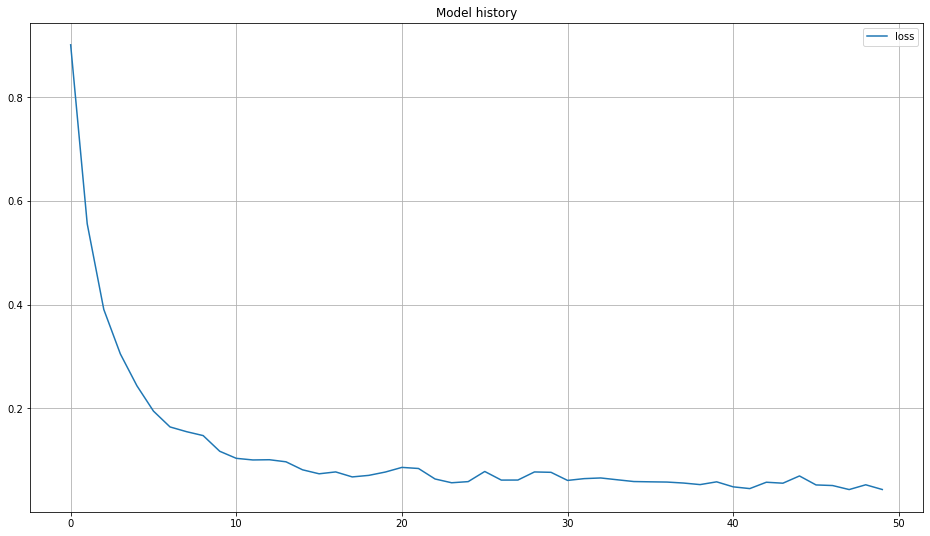

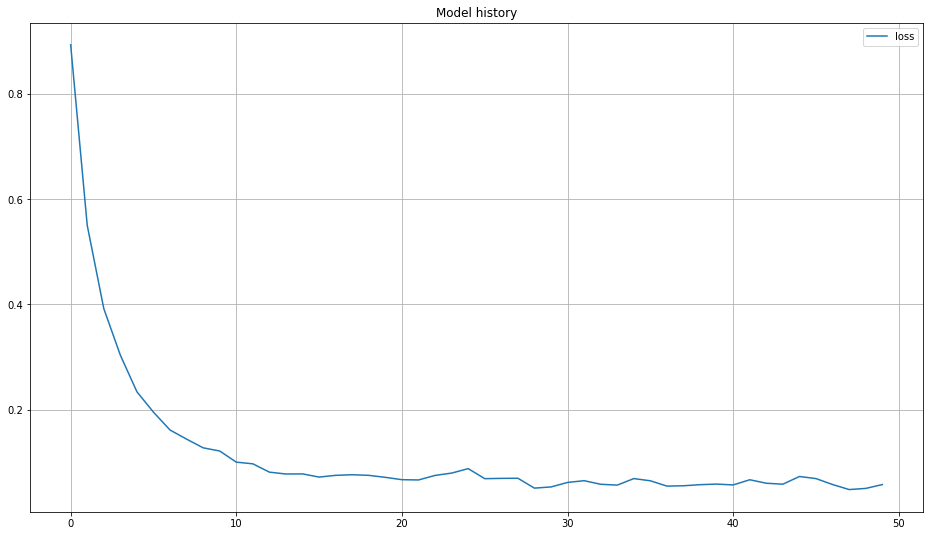

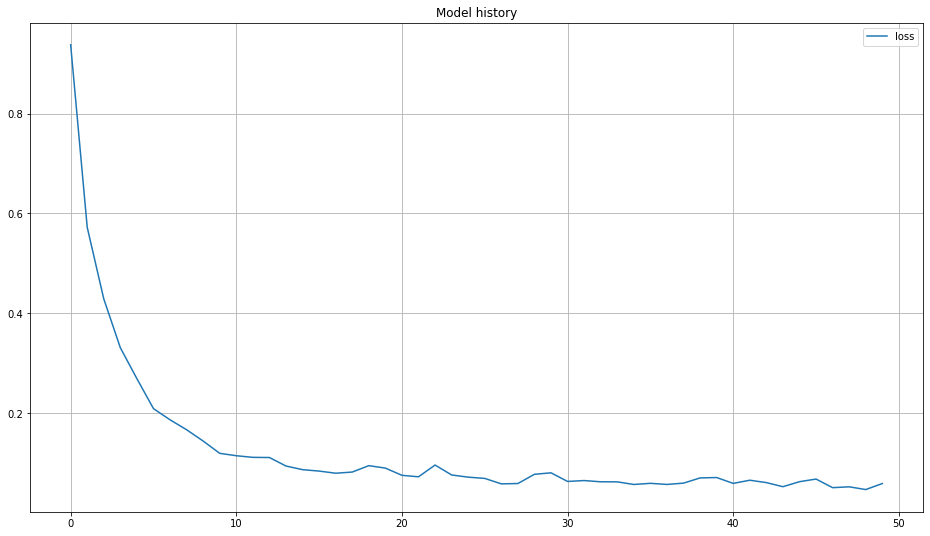

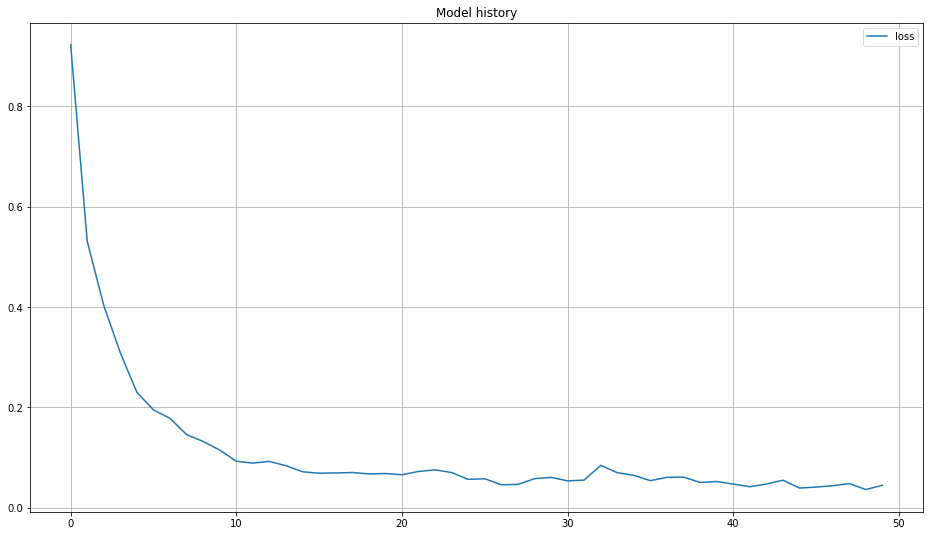

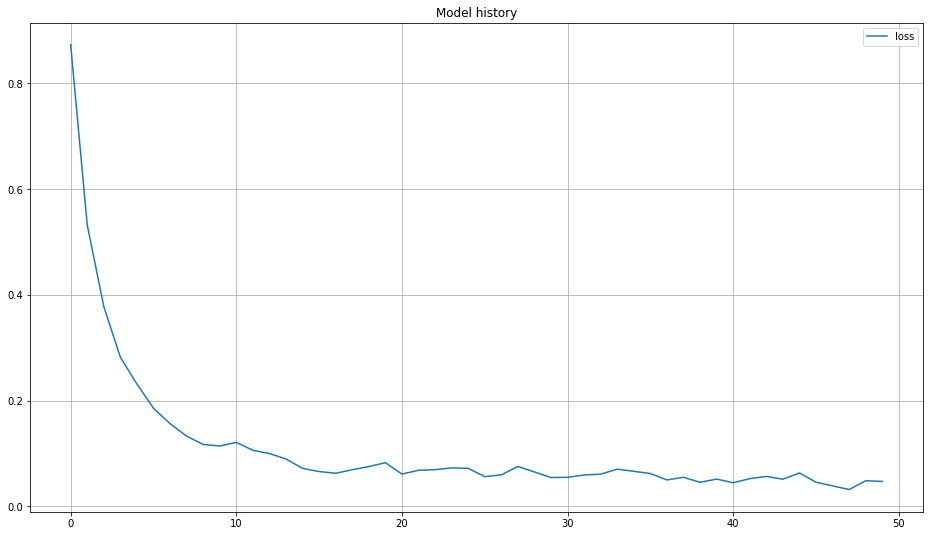

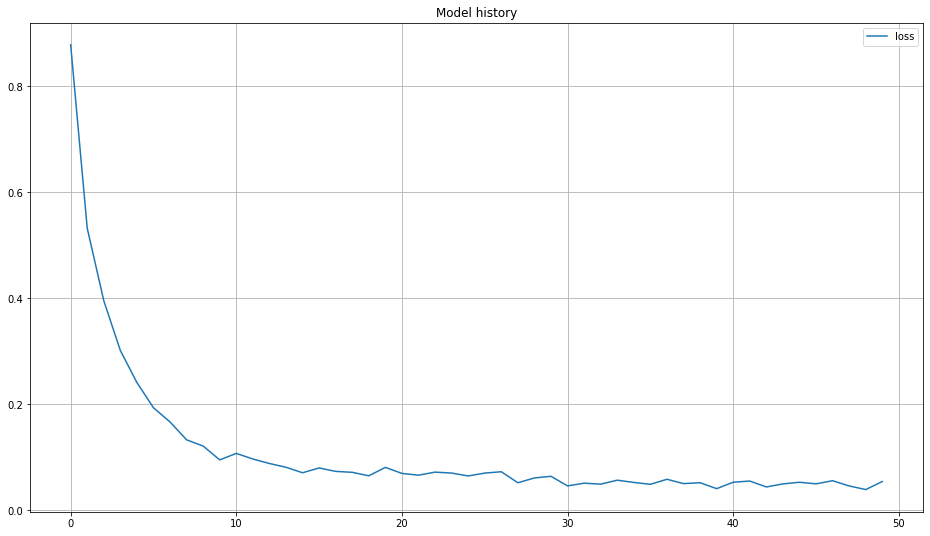

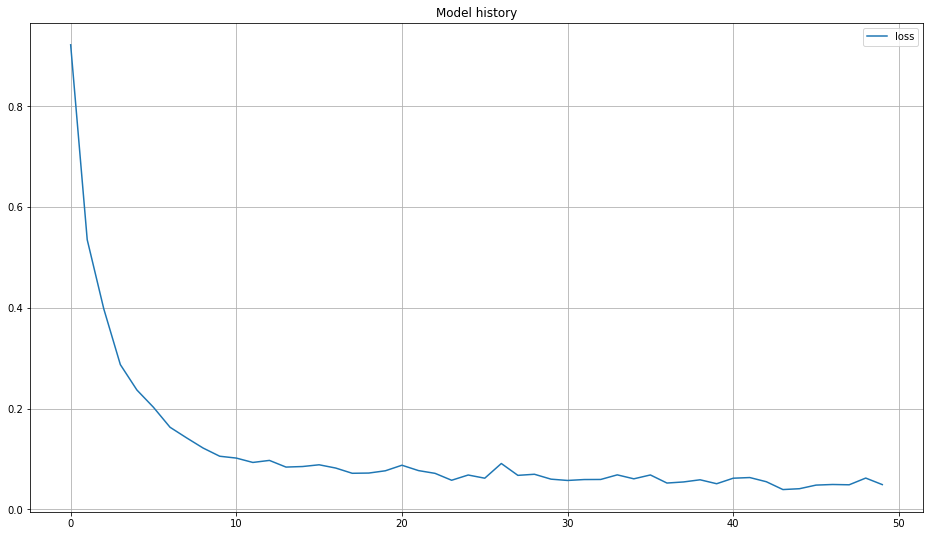

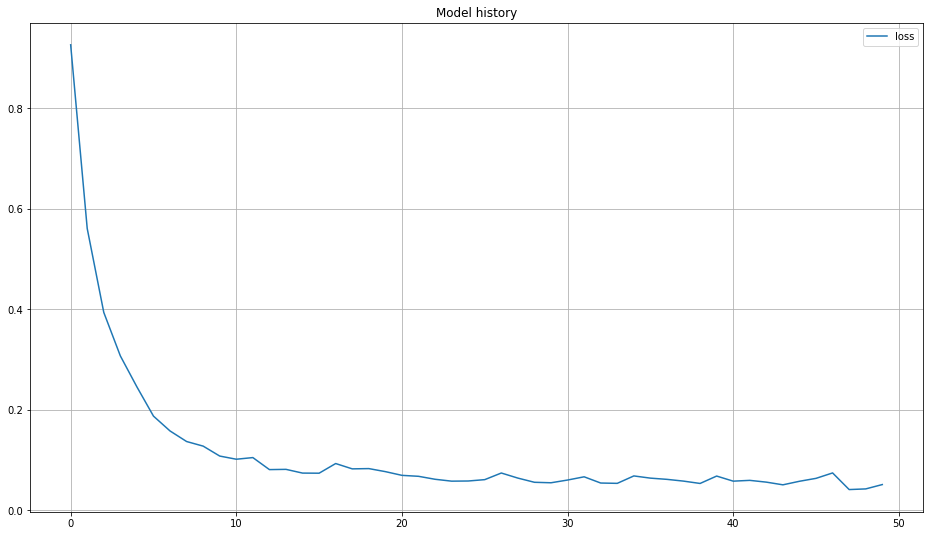

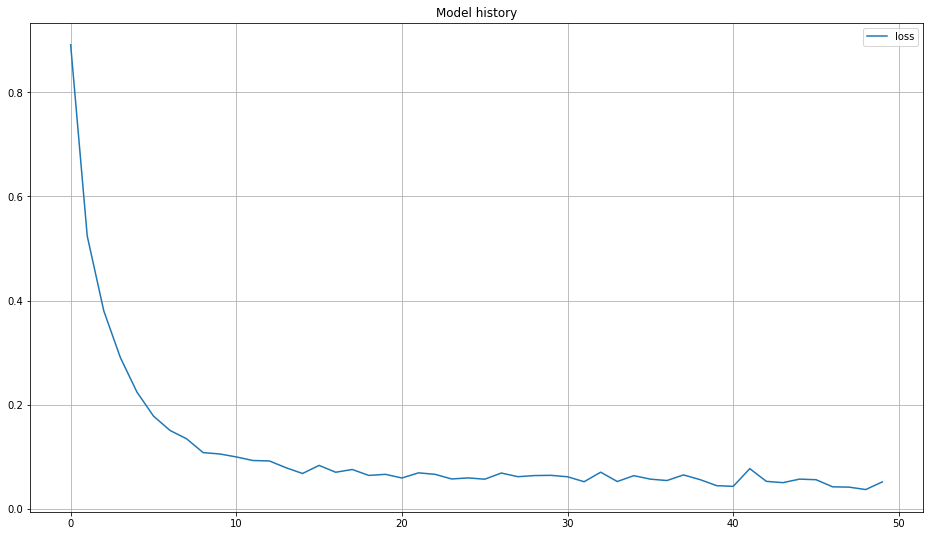

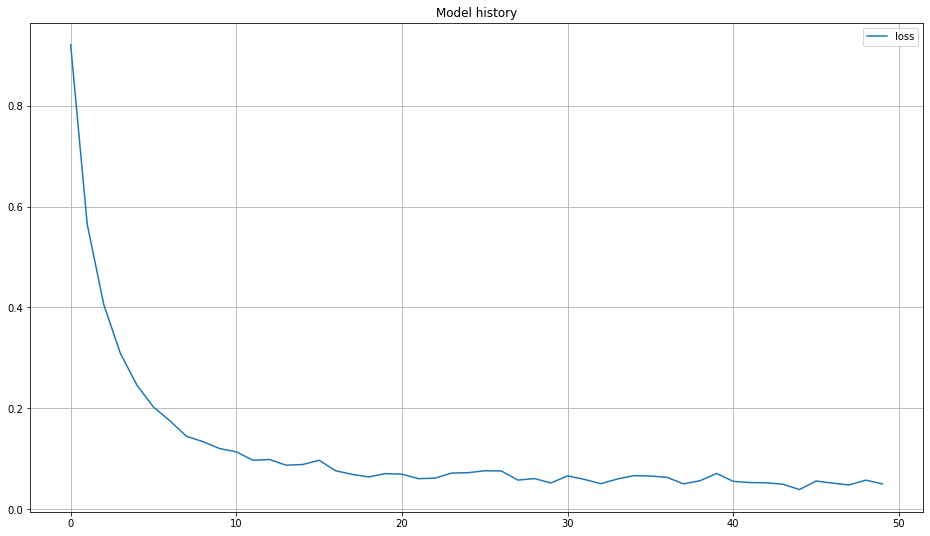

In [15]:
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
NUM_RUNS = 10
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)


for i in range(NUM_RUNS):
    model = build_base_model()
    trainHistory = model.fit(data_train_vgg16, labels_train_mv_bin, epochs=N_EPOCHS, shuffle=True, batch_size=BATCH_SIZE, verbose=2)

    # Create the history figure
    plt.figure(figsize=(16,9))
    for g in  trainHistory.history:
        plt.plot( trainHistory.history[g],label=g)
    plt.title('Model history')
    plt.legend()
    plt.grid()

    accuracy_test = eval_model(model, data_test_vgg16,labels_test)
    print ("Accuracy: Test: %.3f" % (accuracy_test,) )
    ACC[i] =  accuracy_test 
       #AUC =======================
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)
    val_logits = model(data_test_vgg16, training=False)
    # tf.print(y_batch_val)
    val_AUC_metric.update_state( labels_test, val_logits[:,:N_CLASSES].numpy().argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation AUC: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC
    val_AUC1 = roc_auc_score(ook(labels_test),  val_logits[:,:N_CLASSES])
    print("Validation aUc_Sklearn: %.4f" % (float(val_AUC1),))
    AUC[i] = val_AUC1
    #===================================================
  # balanced. Accurcy
    BACC[i] = balanced_accuracy_score(labels_test.squeeze(), val_logits.numpy().argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

    #MI
    
    MI[i] = mutual_info_score(labels_test.squeeze(), val_logits.numpy().argmax(axis=1).squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] = normalized_mutual_info_score(labels_test.squeeze(), val_logits.numpy().argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= adjusted_mutual_info_score(labels_test.squeeze(), val_logits.numpy().argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))




In [16]:
ACC

array([0.76936027, 0.78451178, 0.78282828, 0.77525253, 0.76094276,
       0.78282828, 0.77946128, 0.77020202, 0.77946128, 0.76767677])

In [17]:
AUC

array([0.97723226, 0.97847529, 0.97578988, 0.97431605, 0.97629022,
       0.97574602, 0.97519825, 0.97862791, 0.97736999, 0.97598084])

In [18]:
print('Average Accuracy: ', np.round(ACC.mean(),4)*100) 
print('STD Accuracy: ', np.round(np.std(ACC),4)*100) 

Average Accuracy:  77.53
STD Accuracy:  0.75


In [19]:
print('Average Accuracy: ', np.round( AUC.mean(),4)*100) 
print('Average std: ',np.round(np.std( AUC),4)*100)

Average Accuracy:  97.65
Average std:  0.13


In [20]:
import pickle

# create the dictionary with 6 scalar variables
Metrics = {
    'Accuracy': np.round( ACC.mean(),4)*100,
    'Accuracy_std': np.round(np.std( ACC),4)*100,
    'AUC': np.round( AUC.mean(),4)*100,
    'AUC_std': np.round(np.std( AUC),4)*100,
    'Balanced Accuracy': np.round( BACC.mean(),4)*100,
    'Balanced Accuracy_std':  np.round(np.std(BACC),4)*100,
    'MI': np.round( MI.mean(),4)*100,
    'MI_std': np.round(np.std(MI),4)*100,
    'Normalized MI': np.round( NMI.mean(),4)*100,
    'Normalized MI_std': np.round(np.std(NMI),4)*100,
    'Adjusted MI': np.round( AMI.mean(),4)*100,
    'Adjusted MI_std': np.round(np.std(NMI),4)*100,
}

# save the dictionary to a file using pickle
with open('data.pickle', 'wb') as handle:
    pickle.dump(Metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [21]:
Metrics

{'Accuracy': 77.53,
 'Accuracy_std': 0.75,
 'AUC': 97.65,
 'AUC_std': 0.13,
 'Balanced Accuracy': 75.71,
 'Balanced Accuracy_std': 0.69,
 'MI': 139.95,
 'MI_std': 0.86,
 'Normalized MI': 68.47,
 'Normalized MI_std': 0.44,
 'Adjusted MI': 68.15,
 'Adjusted MI_std': 0.44}